# DESAFIO TÉCNICO CIENTISTA DE DADOS

# Case
Uma empresa alimentícia situada no RJ deseja abrir filiais na cidade de
São Paulo, tendo como público alvo adultos de 25 a 50 anos, das
classes A (rendas A1 e A2) e B (rendas B1 e B2)

In [140]:
#visualization/structues libraries
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
from typing import List, Tuple
import missingno
import yellowbrick.cluster
import featuretools as ft

import sklearn.cluster
import sklearn.datasets
import sklearn.metrics
import sklearn.preprocessing

import scipy.stats
import scipy.optimize
import scipy.integrate

# Stats libs
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api         as sm
import statsmodels.formula.api as smf
import os
import warnings

# Modelling libs
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV

# Metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn import metrics, preprocessing, tree
from sklearn.metrics import f1_score, make_scorer
from yellowbrick.classifier.rocauc import roc_auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import cross_val_score

# Feature importance
from sklearn.inspection import permutation_importance

# Categorical encoders/preprocessing
from category_encoders.target_encoder import TargetEncoder
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Others
from matplotlib.dates import DateFormatter
from statsmodels.tsa.stattools import adfuller

sns.set(font_scale=1.2, style="whitegrid")



warnings.filterwarnings("ignore")

# Creating usefull functions

In [141]:
#Function to format correlation matrix
def plot_corr_matrix(corr_matrix, size=(14, 14)):
  # Set up the matplotlib figure
  fig, ax = plt.subplots(figsize=size)

  # Generate a custom diverging colormap
  cmap = sns.diverging_palette(220, 10, as_cmap=True)

  # Generate a mask for the upper triangle
  mask = np.triu(np.ones_like(corr_matrix.corr(), dtype=np.bool))

  # Draw the heatmap with the mask and correct aspect ratio
  sns.heatmap(corr_matrix.corr(), mask=mask, cmap=cmap, vmax=.99, center=0,
              square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
#Function for calculating VIF
def calc_vif(df):
  """ 
    Variable Inflation Factors
    VIF determines the strength of the correlation between the independent variables. It is predicted by taking a variable and regressing it against every other variable.
    Reference: https://www.analyticsvidhya.com/blog/2020/03/what-is-multicollinearity/#:~:text=Fixing%20Multicollinearity-,What%20is%20Multicollinearity%3F,variable%20in%20a%20regression%20model.
  """
  # Calculating VIF
  vif = pd.DataFrame()
  vif["variables"] = df.columns
  vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

  return(vif)

#Function to plot the VIF
def plot_vif(vif):
  print('vars: ', list(vif.columns))
  print('Variable Inflation Factors:', vif.VIF.sum(), '\n')
    
#Function to Feature importances
def get_lgbm_varimp(model, train_columns, max_vars=50):
    
    if "basic.Booster" in str(model.__class__):
        # lightgbm.basic.Booster was trained directly, so using feature_importance() function 
        cv_varimp_df = pd.DataFrame([train_columns, model.feature_importance()]).Tfeature_importance
    else:
        # Scikit-learn API LGBMClassifier or LGBMRegressor was fitted, 
        # so using feature_importances_ property
        cv_varimp_df = pd.DataFrame([train_columns, model.feature_importances_]).T

    cv_varimp_df.columns = ['feature_name', 'varimp']

    cv_varimp_df.sort_values(by='varimp', ascending=False, inplace=True)

    cv_varimp_df = cv_varimp_df.iloc[0:max_vars]   

    return cv_varimp_df

# Function for constructing bar chart
def grafico_barras_prop(data, variable):
    (data[[variable]]
     .value_counts(normalize=True, sort = False)
     .rename("Proportion")
     .reset_index()
     .pipe((sns.barplot, "data"), x=variable, y="Proportion"))
    plt.ylim(0,1)
    plt.show()
    
# Função de métricas
def metrics_report(y, y_pred, dataset_name='valid'):
  mean_y = np.mean(y)
  mean_pred = np.mean(y_pred)

  rmse = round(math.sqrt(mean_squared_error(y, y_pred)), 2)
  mae = mean_absolute_error(y, y_pred)
  r2 = r2_score(y, y_pred)
  mape = mean_absolute_percentage_error(y, y_pred)
  
  report = pd.DataFrame({
    'metric': ['RMSE', 'MAE', 'R^2', 'MAPE', 'Avg. target', 'Avg. Prediction'],
    dataset_name: [rmse, mae, r2, mape, mean_y, mean_pred]
  })

  report[dataset_name] = report[dataset_name].round(2)
  return report
    

# Importing the datas the "/data" folder

In [142]:
# Reading the first database
df = pd.read_csv("C:/Users/Luiz Philipe Rangel/Documents/GitHub/Desafio Tecnico - GridSearch&FeatureEnginnering/DadosDesafioCientista.csv")

In [143]:
df.shape

(456, 24)

In [144]:
df

,codigo,nome,cidade,estado,população,popAte9,popDe10a14,popDe15a19,popDe20a24,popDe25a34,...,domiciliosA2,domiciliosB1,domiciliosB2,domiciliosC1,domiciliosC2,domiciliosD,domiciliosE,rendaMedia,faturamento,potencial
0,3304557060,Abolição,Rio de Janeiro,RJ,11676,1027,483,688,800,1675,...,145,715,1242,1093,758,92,304,2501,932515.0,Médio
1,3304557138,Acari,Rio de Janeiro,RJ,27564,5131,2188,2697,2630,4810,...,0,82,506,2040,2490,827,2506,931,588833.0,Baixo
2,3304557057,Água Santa,Rio de Janeiro,RJ,9003,883,399,597,762,1755,...,96,404,652,644,522,77,254,2391,874200.0,Baixo
3,3304557031,Alto Da Boa Vista,Rio de Janeiro,RJ,9606,1072,538,660,685,1317,...,178,393,517,945,584,137,286,3727,912226.0,Médio
4,3304557125,Anchieta,Rio de Janeiro,RJ,57222,7677,3774,4892,4600,8660,...,0,1089,2821,5110,5422,1073,3261,1380,553020.0,Médio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,355030213,Vila Sônia,São Paulo,SP,34061,2908,1462,2253,2076,4579,...,1089,2866,2219,2216,1227,306,1098,5285,NaN,NaN
452,355030207,Vila Suzana,São Paulo,SP,35403,4127,1890,2678,2433,5855,...,1522,2458,1186,1166,918,209,3840,7418,NaN,NaN
453,355030162,Vila Terezinha,São Paulo,SP,122359,18304,9304,13258,9965,19248,...,0,1758,4517,9450,11473,3218,7540,1252,NaN,NaN
454,355030157,Vila Zatt,São Paulo,SP,125864,14670,7305,11225,9338,18841,...,872,5093,8063,10012,8082,2856,6853,1936,NaN,NaN


In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456 entries, 0 to 455
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   codigo        456 non-null    int64  
 1   nome          456 non-null    object 
 2   cidade        456 non-null    object 
 3   estado        456 non-null    object 
 4   população     456 non-null    int64  
 5   popAte9       456 non-null    int64  
 6   popDe10a14    456 non-null    int64  
 7   popDe15a19    456 non-null    int64  
 8   popDe20a24    456 non-null    int64  
 9   popDe25a34    456 non-null    int64  
 10  popDe35a49    456 non-null    int64  
 11  popDe50a59    456 non-null    int64  
 12  popMaisDe60   456 non-null    int64  
 13  domiciliosA1  456 non-null    int64  
 14  domiciliosA2  456 non-null    int64  
 15  domiciliosB1  456 non-null    int64  
 16  domiciliosB2  456 non-null    int64  
 17  domiciliosC1  456 non-null    int64  
 18  domiciliosC2  456 non-null    

In [146]:
df.describe()

,codigo,população,popAte9,popDe10a14,popDe15a19,popDe20a24,popDe25a34,popDe35a49,popDe50a59,popMaisDe60,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,domiciliosC1,domiciliosC2,domiciliosD,domiciliosE,faturamento
count,4.560000e+02,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000,456.000000,456.00000,1.600000e+02
mean,1.321422e+09,41355.605263,5005.274123,2406.013158,3475.328947,3135.839912,6491.019737,9028.614035,5169.234649,6644.280702,405.583333,580.782895,1897.436404,2297.436404,3161.679825,2788.192982,689.153509,2191.58114,8.761600e+05
std,1.464724e+09,47188.920422,7655.796985,3617.925729,4571.058622,4030.380079,7012.670205,9277.870455,5676.876617,6929.255870,1044.795780,1074.031736,2130.830989,2138.179024,3453.936815,3441.066392,948.425756,2380.59873,4.382106e+05
min,3.550301e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,2.465100e+04
25%,3.550301e+08,14616.750000,1324.000000,604.250000,956.000000,1006.000000,2273.500000,3245.250000,1918.500000,2708.750000,0.000000,3.000000,559.750000,841.250000,934.000000,554.750000,96.500000,557.75000,7.112785e+05
50%,3.550302e+08,30352.000000,3074.000000,1434.000000,2173.000000,2196.000000,4774.000000,6710.500000,3951.500000,5264.500000,0.000000,198.500000,1334.000000,1833.000000,2229.000000,1632.500000,348.500000,1494.50000,8.242285e+05
75%,3.304557e+09,50879.250000,5962.000000,2884.000000,4307.500000,3762.750000,7828.500000,11272.750000,6620.500000,8745.500000,345.250000,757.500000,2500.500000,3222.250000,4153.250000,3679.500000,825.500000,2863.75000,9.343208e+05
max,3.304557e+09,667603.000000,122578.000000,55935.000000,62342.000000,60567.000000,86116.000000,105316.000000,83341.000000,91408.000000,13408.000000,11668.000000,19350.000000,21237.000000,33111.000000,25779.000000,6680.000000,15001.00000,2.915612e+06


In [147]:
#Evaluating the percentage of missing cases
df.isnull().mean().round(5)*100

codigo           0.000
nome             0.000
cidade           0.000
estado           0.000
população        0.000
popAte9          0.000
popDe10a14       0.000
popDe15a19       0.000
popDe20a24       0.000
popDe25a34       0.000
popDe35a49       0.000
popDe50a59       0.000
popMaisDe60      0.000
domiciliosA1     0.000
domiciliosA2     0.000
domiciliosB1     0.000
domiciliosB2     0.000
domiciliosC1     0.000
domiciliosC2     0.000
domiciliosD      0.000
domiciliosE      0.000
rendaMedia       1.316
faturamento     64.912
potencial       64.912
dtype: float64

In [148]:
df.columns

Index(['codigo', 'nome', 'cidade', 'estado', 'população', 'popAte9',
       'popDe10a14', 'popDe15a19', 'popDe20a24', 'popDe25a34', 'popDe35a49',
       'popDe50a59', 'popMaisDe60', 'domiciliosA1', 'domiciliosA2',
       'domiciliosB1', 'domiciliosB2', 'domiciliosC1', 'domiciliosC2',
       'domiciliosD', 'domiciliosE', 'rendaMedia', 'faturamento', 'potencial'],
      dtype='object')

In [149]:
#separando o df para teste - todos que são nulos
df_teste = df[df['faturamento'].isnull()]


In [150]:
teste = df_teste.iloc[ : , 0:22]

In [151]:
teste

,codigo,nome,cidade,estado,população,popAte9,popDe10a14,popDe15a19,popDe20a24,popDe25a34,...,popMaisDe60,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,domiciliosC1,domiciliosC2,domiciliosD,domiciliosE,rendaMedia
160,355030251,A. E. Carvalho,São Paulo,SP,94034,12668,6853,9836,7487,14535,...,10508,0,253,2197,4368,6681,7011,2247,5670,1501
161,35503020,Aclimação,São Paulo,SP,32791,2297,1017,2096,2197,5341,...,7645,1413,1734,3704,2351,1946,827,291,1617,5920
162,355030285,Adventista,São Paulo,SP,104193,15070,7343,10631,8657,17749,...,9812,0,0,1423,4875,8595,10082,3111,5776,1284
163,35503088,Água Branca,São Paulo,SP,12721,953,343,627,819,2142,...,3214,624,667,1558,1032,915,361,84,404,6278
164,35503066,Água Funda,São Paulo,SP,48417,5078,2396,4018,3571,7388,...,8567,0,303,1794,2986,4489,2836,1104,2553,1905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,355030213,Vila Sônia,São Paulo,SP,34061,2908,1462,2253,2076,4579,...,7999,942,1089,2866,2219,2216,1227,306,1098,5285
452,355030207,Vila Suzana,São Paulo,SP,35403,4127,1890,2678,2433,5855,...,4705,1726,1522,2458,1186,1166,918,209,3840,7418
453,355030162,Vila Terezinha,São Paulo,SP,122359,18304,9304,13258,9965,19248,...,13109,0,0,1758,4517,9450,11473,3218,7540,1252
454,355030157,Vila Zatt,São Paulo,SP,125864,14670,7305,11225,9338,18841,...,19285,8,872,5093,8063,10012,8082,2856,6853,1936


In [152]:
#Delete null
df = df.dropna()

In [153]:
df

,codigo,nome,cidade,estado,população,popAte9,popDe10a14,popDe15a19,popDe20a24,popDe25a34,...,domiciliosA2,domiciliosB1,domiciliosB2,domiciliosC1,domiciliosC2,domiciliosD,domiciliosE,rendaMedia,faturamento,potencial
0,3304557060,Abolição,Rio de Janeiro,RJ,11676,1027,483,688,800,1675,...,145,715,1242,1093,758,92,304,2501,932515.0,Médio
1,3304557138,Acari,Rio de Janeiro,RJ,27564,5131,2188,2697,2630,4810,...,0,82,506,2040,2490,827,2506,931,588833.0,Baixo
2,3304557057,Água Santa,Rio de Janeiro,RJ,9003,883,399,597,762,1755,...,96,404,652,644,522,77,254,2391,874200.0,Baixo
3,3304557031,Alto Da Boa Vista,Rio de Janeiro,RJ,9606,1072,538,660,685,1317,...,178,393,517,945,584,137,286,3727,912226.0,Médio
4,3304557125,Anchieta,Rio de Janeiro,RJ,57222,7677,3774,4892,4600,8660,...,0,1089,2821,5110,5422,1073,3261,1380,553020.0,Médio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,3304557062,Vila Kosmos,Rio de Janeiro,RJ,18791,1802,921,1442,1462,2500,...,259,774,1363,1923,1379,190,405,2316,901446.0,Médio
156,3304557093,Vila Militar,Rio de Janeiro,RJ,13556,1888,787,1042,982,2542,...,219,714,828,1051,1012,116,465,2416,849731.0,Médio
157,3304557091,Vila Valqueire,Rio de Janeiro,RJ,33190,3166,1619,2255,2326,4752,...,906,2866,2241,2982,1200,360,772,3189,1127042.0,Alto
158,3304557065,Vista Alegre,Rio de Janeiro,RJ,8867,724,387,580,565,1205,...,87,556,836,940,484,75,214,2418,921875.0,Baixo


In [154]:
#Transformar a coluna rendamedia em numérico
df['rendaMedia'] = pd.to_numeric(df['rendaMedia'],errors = 'coerce')
teste['rendaMedia'] = pd.to_numeric(teste['rendaMedia'],errors = 'coerce')

In [155]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 154 entries, 0 to 159
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   codigo        154 non-null    int64  
 1   nome          154 non-null    object 
 2   cidade        154 non-null    object 
 3   estado        154 non-null    object 
 4   população     154 non-null    int64  
 5   popAte9       154 non-null    int64  
 6   popDe10a14    154 non-null    int64  
 7   popDe15a19    154 non-null    int64  
 8   popDe20a24    154 non-null    int64  
 9   popDe25a34    154 non-null    int64  
 10  popDe35a49    154 non-null    int64  
 11  popDe50a59    154 non-null    int64  
 12  popMaisDe60   154 non-null    int64  
 13  domiciliosA1  154 non-null    int64  
 14  domiciliosA2  154 non-null    int64  
 15  domiciliosB1  154 non-null    int64  
 16  domiciliosB2  154 non-null    int64  
 17  domiciliosC1  154 non-null    int64  
 18  domiciliosC2  154 non-null    

In [156]:
teste.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296 entries, 160 to 455
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   codigo        296 non-null    int64  
 1   nome          296 non-null    object 
 2   cidade        296 non-null    object 
 3   estado        296 non-null    object 
 4   população     296 non-null    int64  
 5   popAte9       296 non-null    int64  
 6   popDe10a14    296 non-null    int64  
 7   popDe15a19    296 non-null    int64  
 8   popDe20a24    296 non-null    int64  
 9   popDe25a34    296 non-null    int64  
 10  popDe35a49    296 non-null    int64  
 11  popDe50a59    296 non-null    int64  
 12  popMaisDe60   296 non-null    int64  
 13  domiciliosA1  296 non-null    int64  
 14  domiciliosA2  296 non-null    int64  
 15  domiciliosB1  296 non-null    int64  
 16  domiciliosB2  296 non-null    int64  
 17  domiciliosC1  296 non-null    int64  
 18  domiciliosC2  296 non-null  

In [157]:
# Dropando os dados que não vamos utilizar do df
df_final = df.drop(['codigo','popAte9','popDe10a14','popDe15a19'],axis=1)


In [158]:
df_final

,nome,cidade,estado,população,popDe20a24,popDe25a34,popDe35a49,popDe50a59,popMaisDe60,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,domiciliosC1,domiciliosC2,domiciliosD,domiciliosE,rendaMedia,faturamento,potencial
0,Abolição,Rio de Janeiro,RJ,11676,800,1675,2300,1784,2919,0,145,715,1242,1093,758,92,304,2501,932515.0,Médio
1,Acari,Rio de Janeiro,RJ,27564,2630,4810,5308,2403,2397,0,0,82,506,2040,2490,827,2506,931,588833.0,Baixo
2,Água Santa,Rio de Janeiro,RJ,9003,762,1755,2076,1112,1419,0,96,404,652,644,522,77,254,2391,874200.0,Baixo
3,Alto Da Boa Vista,Rio de Janeiro,RJ,9606,685,1317,2007,1341,1986,114,178,393,517,945,584,137,286,3727,912226.0,Médio
4,Anchieta,Rio de Janeiro,RJ,57222,4600,8660,12272,7157,8190,0,0,1089,2821,5110,5422,1073,3261,1380,553020.0,Médio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,Vila Kosmos,Rio de Janeiro,RJ,18791,1462,2500,3944,2920,3800,0,259,774,1363,1923,1379,190,405,2316,901446.0,Médio
156,Vila Militar,Rio de Janeiro,RJ,13556,982,2542,2908,1528,1879,0,219,714,828,1051,1012,116,465,2416,849731.0,Médio
157,Vila Valqueire,Rio de Janeiro,RJ,33190,2326,4752,7183,4950,6939,0,906,2866,2241,2982,1200,360,772,3189,1127042.0,Alto
158,Vista Alegre,Rio de Janeiro,RJ,8867,565,1205,1812,1474,2120,0,87,556,836,940,484,75,214,2418,921875.0,Baixo


In [159]:
# Dropando os dados que não vamos utilizar do teste
teste_final = teste.drop(['codigo','popAte9','popDe10a14','popDe15a19'],axis=1)


In [160]:
teste_final

,nome,cidade,estado,população,popDe20a24,popDe25a34,popDe35a49,popDe50a59,popMaisDe60,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,domiciliosC1,domiciliosC2,domiciliosD,domiciliosE,rendaMedia
160,A. E. Carvalho,São Paulo,SP,94034,7487,14535,21549,10598,10508,0,253,2197,4368,6681,7011,2247,5670,1501.0
161,Aclimação,São Paulo,SP,32791,2197,5341,7281,4917,7645,1413,1734,3704,2351,1946,827,291,1617,5920.0
162,Adventista,São Paulo,SP,104193,8657,17749,23364,11567,9812,0,0,1423,4875,8595,10082,3111,5776,1284.0
163,Água Branca,São Paulo,SP,12721,819,2142,2833,1790,3214,624,667,1558,1032,915,361,84,404,6278.0
164,Água Funda,São Paulo,SP,48417,3571,7388,10751,6648,8567,0,303,1794,2986,4489,2836,1104,2553,1905.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,Vila Sônia,São Paulo,SP,34061,2076,4579,7557,5227,7999,942,1089,2866,2219,2216,1227,306,1098,5285.0
452,Vila Suzana,São Paulo,SP,35403,2433,5855,9107,4608,4705,1726,1522,2458,1186,1166,918,209,3840,7418.0
453,Vila Terezinha,São Paulo,SP,122359,9965,19248,26592,12579,13109,0,0,1758,4517,9450,11473,3218,7540,1252.0
454,Vila Zatt,São Paulo,SP,125864,9338,18841,28500,16700,19285,8,872,5093,8063,10012,8082,2856,6853,1936.0


In [161]:
#Separating the variable of interest
target1 = 'faturamento'
print('target1:', target1)

target2 = 'potencial'
print('target2:', target2)

# Numerical vars
num_vars = df_final.select_dtypes(include=['int', 'float']).columns.tolist()
num_vars.remove(target1)


print(f'numerical vars({len(num_vars)}): {num_vars}')

# categorical vars
cat_vars = df_final.select_dtypes(exclude=['int', 'float']).columns.tolist()
cat_vars.remove(target2)

print(f'categorical vars({len(cat_vars)}): {cat_vars}')

target1: faturamento
target2: potencial
numerical vars(15): ['população', 'popDe20a24', 'popDe25a34', 'popDe35a49', 'popDe50a59', 'popMaisDe60', 'domiciliosA1', 'domiciliosA2', 'domiciliosB1', 'domiciliosB2', 'domiciliosC1', 'domiciliosC2', 'domiciliosD', 'domiciliosE', 'rendaMedia']
categorical vars(3): ['nome', 'cidade', 'estado']


In [162]:
#Analise exploratoria
df_final['logfaturamento'] = np.log(df_final['faturamento'].values)

In [163]:
df_final

,nome,cidade,estado,população,popDe20a24,popDe25a34,popDe35a49,popDe50a59,popMaisDe60,domiciliosA1,...,domiciliosB1,domiciliosB2,domiciliosC1,domiciliosC2,domiciliosD,domiciliosE,rendaMedia,faturamento,potencial,logfaturamento
0,Abolição,Rio de Janeiro,RJ,11676,800,1675,2300,1784,2919,0,...,715,1242,1093,758,92,304,2501,932515.0,Médio,13.745641
1,Acari,Rio de Janeiro,RJ,27564,2630,4810,5308,2403,2397,0,...,82,506,2040,2490,827,2506,931,588833.0,Baixo,13.285898
2,Água Santa,Rio de Janeiro,RJ,9003,762,1755,2076,1112,1419,0,...,404,652,644,522,77,254,2391,874200.0,Baixo,13.681064
3,Alto Da Boa Vista,Rio de Janeiro,RJ,9606,685,1317,2007,1341,1986,114,...,393,517,945,584,137,286,3727,912226.0,Médio,13.723643
4,Anchieta,Rio de Janeiro,RJ,57222,4600,8660,12272,7157,8190,0,...,1089,2821,5110,5422,1073,3261,1380,553020.0,Médio,13.223149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,Vila Kosmos,Rio de Janeiro,RJ,18791,1462,2500,3944,2920,3800,0,...,774,1363,1923,1379,190,405,2316,901446.0,Médio,13.711755
156,Vila Militar,Rio de Janeiro,RJ,13556,982,2542,2908,1528,1879,0,...,714,828,1051,1012,116,465,2416,849731.0,Médio,13.652675
157,Vila Valqueire,Rio de Janeiro,RJ,33190,2326,4752,7183,4950,6939,0,...,2866,2241,2982,1200,360,772,3189,1127042.0,Alto,13.935107
158,Vista Alegre,Rio de Janeiro,RJ,8867,565,1205,1812,1474,2120,0,...,556,836,940,484,75,214,2418,921875.0,Baixo,13.734165


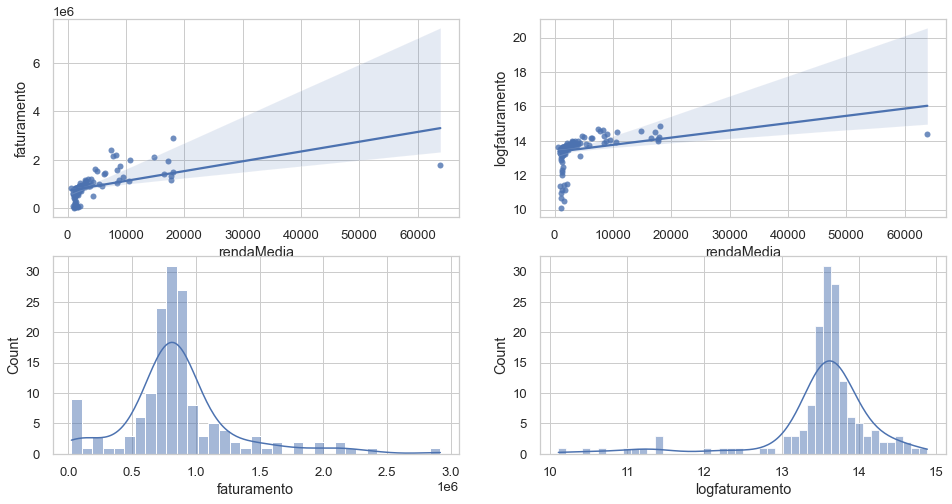

In [164]:
fig, axs = plt.subplots(figsize=(16,8), ncols=2, nrows=2)

sns.histplot(x=df_final.faturamento, kde=True, ax=axs[1][0])
sns.histplot(x=df_final.logfaturamento, kde=True, ax=axs[1][1])

sns.regplot(x='rendaMedia', y='faturamento', data=df_final, ax=axs[0][0])
sns.regplot(x='rendaMedia', y='logfaturamento', data=df_final, ax=axs[0][1])

plt.show()

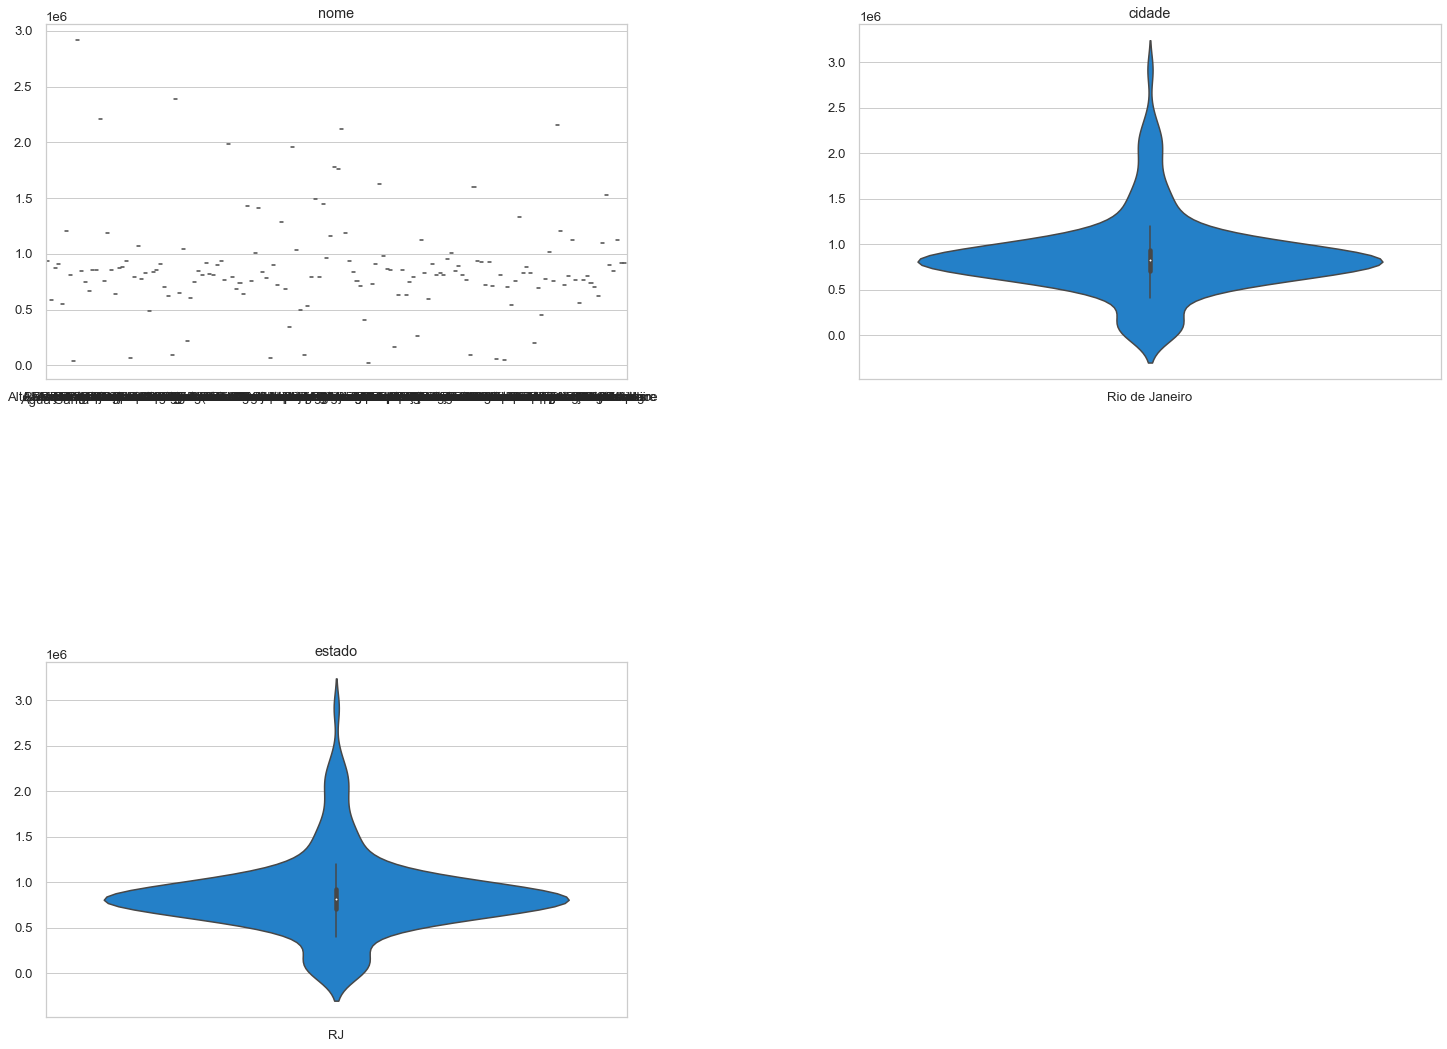

In [165]:
# Configurando a figura do matplot lib
fig = plt.figure(figsize=(25,30))
fig.subplots_adjust(hspace=0.8, wspace=0.4)

total_plots = len(cat_vars)
i = 0
# Iterando para todas variaveis categoricas
for var in cat_vars:
    # Pegando o index certo para plotar o grafico
    ax = fig.add_subplot(total_plots, 2, i+1)
    # Desenhando o grafico do tipo violinplot
    sns.violinplot(x=var, y=target1, color='#0984e3', title=var,data=df_final, ax=ax)
    ax.set_title(var)
    ax.set_ylabel('')
    ax.set_xlabel('')
    i += 1

plt.show()

Text(0.0, 1.0, 'Correlation Matrix')

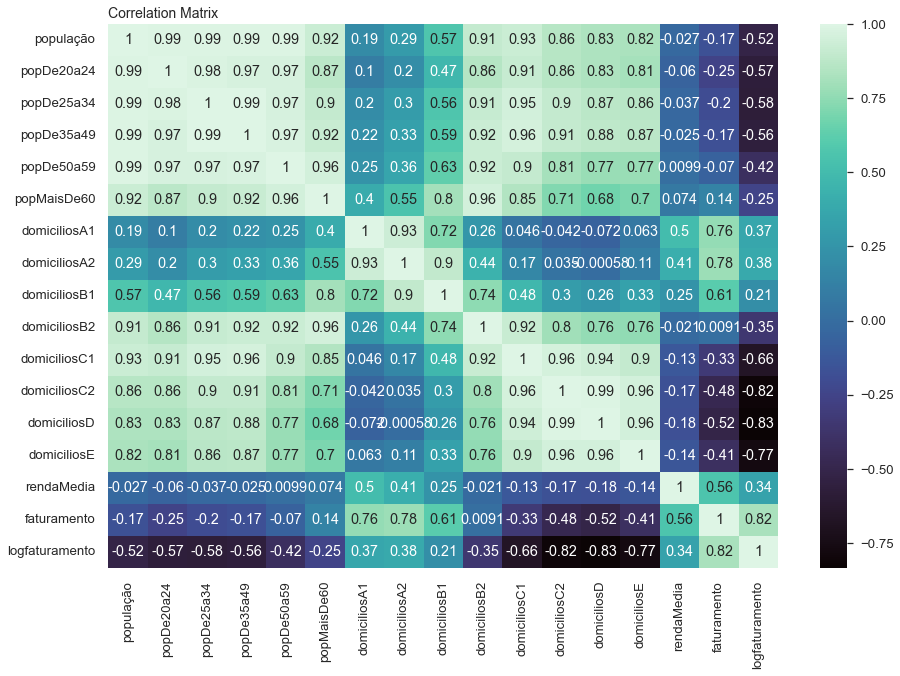

In [166]:
#Verificando a correlação entre as variáveis númericas
plt.figure(figsize=(15,10))
ax = sns.heatmap(df_final.corr(), annot=True, cmap = 'mako')
plt.title('Correlation Matrix', fontsize = 14, loc = 'left')

In [29]:
corr_matrix = df_final[num_vars + [target1]].corr()
corr_matrix[target1].sort_values(ascending=False)

faturamento     1.000000
domiciliosA2    0.781901
domiciliosA1    0.757360
domiciliosB1    0.611988
rendaMedia      0.556335
popMaisDe60     0.137654
domiciliosB2    0.009096
popDe50a59     -0.070451
população      -0.169300
popDe35a49     -0.174759
popDe25a34     -0.198317
popDe20a24     -0.252967
domiciliosC1   -0.327108
domiciliosE    -0.414675
domiciliosC2   -0.481882
domiciliosD    -0.515005
Name: faturamento, dtype: float64

In [167]:
#Poder preditivo, regressão via random forest
features = num_vars
X = df_final.drop(['faturamento','potencial','nome','cidade','estado','logfaturamento'],axis=1)
y = df_final.faturamento

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=42)

print('X Train shape', X_train.shape)
print('X Test shape', X_test.shape)

X Train shape (107, 15)
X Test shape (47, 15)


In [168]:
#Fitando um RandomForest baseline
rf_baseline = RandomForestRegressor(random_state=42)
# Treino
rf_baseline.fit(X_train, y_train)

y_test_baseline_pred = rf_baseline.predict(X_test)
baseline_report = metrics_report(y_test, y_test_baseline_pred, 'Test')
baseline_report

,metric,Test
0,RMSE,239460.18
1,MAE,118487.99
2,R^2,0.72
3,MAPE,0.72
4,Avg. target,827975.26
5,Avg. Prediction,890204.03


In [169]:
#Achando os melhores hiperparâmetros para o RandomForest

In [170]:
# hiperparams: n_estimators: [], max_features: [], min_samples_leaf: []
for n_estimators in [10, 30, 50, 70, 100, 150, 200]:
  print(f'Random forest, with n_estimators {n_estimators}')
  rf_model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
  rf_model.fit(X_train, y_train)
  y_test_pred = rf_model.predict(X_test)
  rmse = math.sqrt(mean_squared_error(y_test, y_test_pred))
  print(f'rmse: {rmse}\n')

Random forest, with n_estimators 10
rmse: 191539.8707987613

Random forest, with n_estimators 30
rmse: 239522.1155130606

Random forest, with n_estimators 50
rmse: 241072.99998859668

Random forest, with n_estimators 70
rmse: 238455.5433443434

Random forest, with n_estimators 100
rmse: 239460.17618411127

Random forest, with n_estimators 150
rmse: 238212.0300497676

Random forest, with n_estimators 200
rmse: 236440.44878017457



In [171]:
# hiperparams: n_estimators: [10], max_features: [], min_samples_leaf: []
for max_features in ['sqrt', 0.1, 0.2, 0.3, 0.4, 0.6]:
  print(f'Random forest, with max_features {max_features}')
  rf_model = RandomForestRegressor(n_estimators=10, max_features=max_features, random_state=42)
  rf_model.fit(X_train, y_train)
  y_test_pred = rf_model.predict(X_test)
  rmse = math.sqrt(mean_squared_error(y_test, y_test_pred))
  print(f'rmse: {rmse}\n')

Random forest, with max_features sqrt
rmse: 161551.94669671124

Random forest, with max_features 0.1
rmse: 216939.90264109816

Random forest, with max_features 0.2
rmse: 161551.94669671124

Random forest, with max_features 0.3
rmse: 158493.9853754918

Random forest, with max_features 0.4
rmse: 182225.00280602128

Random forest, with max_features 0.6
rmse: 169346.7760680056



In [172]:
# hiperparams: n_estimators: [10], max_features: [0.3], min_samples_leaf: []
for min_samples_leaf in list(range(1,6)):
  print(f'Random forest, with min_samples_leaf {min_samples_leaf}')
  rf_model = RandomForestRegressor(n_estimators=10, max_features=0.3, min_samples_leaf= min_samples_leaf, random_state=42)
  rf_model.fit(X_train, y_train)
  y_test_pred = rf_model.predict(X_test)
  rmse = math.sqrt(mean_squared_error(y_test, y_test_pred))
  print(f'rmse: {rmse}\n')

Random forest, with min_samples_leaf 1
rmse: 158493.9853754918

Random forest, with min_samples_leaf 2
rmse: 149900.41136216582

Random forest, with min_samples_leaf 3
rmse: 141963.7747014112

Random forest, with min_samples_leaf 4
rmse: 148255.11531776097

Random forest, with min_samples_leaf 5
rmse: 154376.49897844455



In [173]:
#Random Forest com os melhores hiperparâmetros

In [174]:
# hiperparams: n_estimators: [10], max_features: [0.3], min_samples_leaf: [3]
rf_model = RandomForestRegressor(n_estimators=10, max_features=0.3, min_samples_leaf= 3, random_state=42)
rf_model.fit(X_train, y_train)
y_test_pred = rf_model.predict(X_test)
metrics_report(y_test, y_test_pred, 'validation')

,metric,validation
0,RMSE,141963.77
1,MAE,87679.15
2,R^2,0.90
3,MAPE,0.33
4,Avg. target,827975.26
5,Avg. Prediction,845072.68


In [175]:
#Importância das features, removendo variáveis pouco importantes
# https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html
print('Running permutation feature importance')
permutation_result = permutation_importance(rf_model, X_test, y_test, n_repeats=5, random_state=42)

Running permutation feature importance


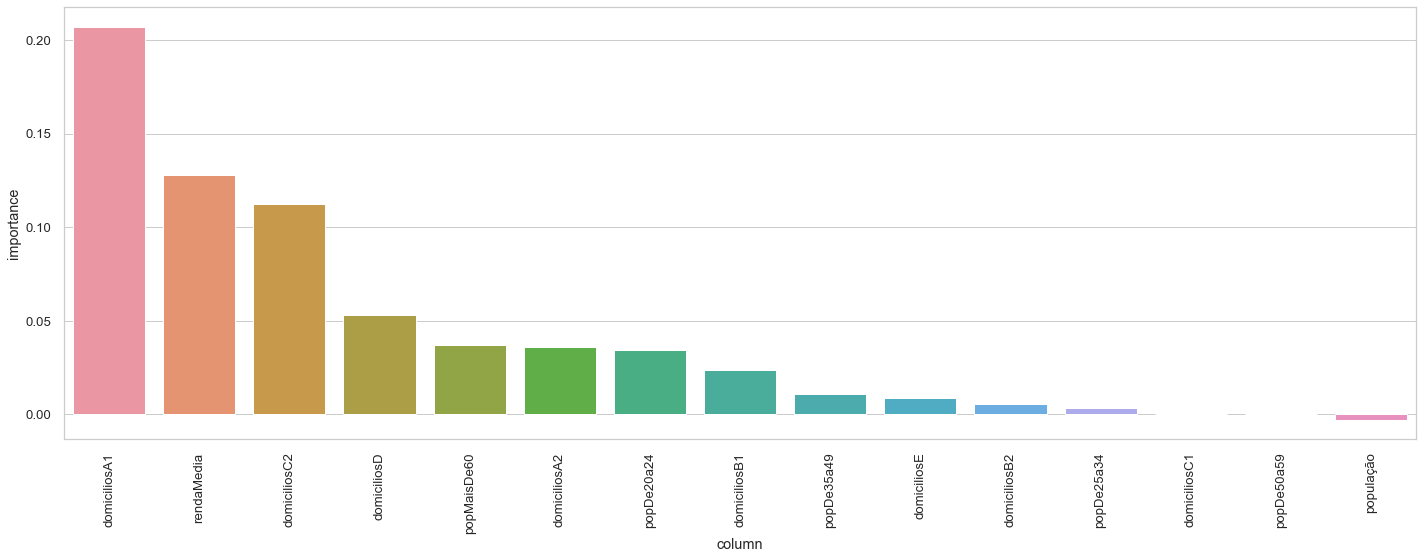

In [176]:
importances = pd.DataFrame({'column' : X_test.columns, 'importance': permutation_result.importances_mean})
importances.sort_values(by='importance', ascending=False, inplace=True)

fig, axs = plt.subplots(figsize=(20,8))
ax = sns.barplot(x='column', y="importance", data=importances)
plt.xticks(rotation=90)
plt.tight_layout()

In [177]:
# Getting the top 12 best features
best_features = importances.head(12).column.tolist()
print(best_features)

['domiciliosA1', 'rendaMedia', 'domiciliosC2', 'domiciliosD', 'popMaisDe60', 'domiciliosA2', 'popDe20a24', 'domiciliosB1', 'popDe35a49', 'domiciliosE', 'domiciliosB2', 'popDe25a34']


In [178]:
# Retreinando o RandomForest apenas com as top 12 variáveis mais importantes

In [179]:
# Fitting the final RandomForest model
rf_model = RandomForestRegressor(n_estimators=10, max_features=0.3, min_samples_leaf= 3, random_state=42)
rf_model.fit(X_train[best_features], y_train)

# Computing predictions
y_train_pred = rf_model.predict(X_train[best_features])
y_test_pred = rf_model.predict(X_test[best_features])

# Computing the train, validation and test model performance metrics
train_report = metrics_report(y_train, y_train_pred, 'train')
test_report = metrics_report(y_test, y_test_pred, 'test')

final_report = pd.concat([train_report,  test_report[['test']]], axis=1)

print(f'Baseline report (total features: {len(features)})')
print(baseline_report)
print('')
print(f'Final report (total features: {len(best_features)})')
print(final_report)

Baseline report (total features: 15)
            metric       Test
0             RMSE  239460.18
1              MAE  118487.99
2              R^2       0.72
3             MAPE       0.72
4      Avg. target  827975.26
5  Avg. Prediction  890204.03

Final report (total features: 12)
            metric      train       test
0             RMSE  119205.65  240078.14
1              MAE   62757.15  121058.64
2              R^2       0.92       0.72
3             MAPE       0.29       1.01
4      Avg. target  888719.01  827975.26
5  Avg. Prediction  886175.22  911283.69


In [180]:
# vamos teste com totas as variáveis
# Getting the top 15 best features
best_features = importances.head(15).column.tolist()
print(best_features)

['domiciliosA1', 'rendaMedia', 'domiciliosC2', 'domiciliosD', 'popMaisDe60', 'domiciliosA2', 'popDe20a24', 'domiciliosB1', 'popDe35a49', 'domiciliosE', 'domiciliosB2', 'popDe25a34', 'domiciliosC1', 'popDe50a59', 'população']


In [181]:
# Fitting the final RandomForest model
rf_model = RandomForestRegressor(n_estimators=10, max_features=0.3, min_samples_leaf= 3, random_state=42)
rf_model.fit(X_train[best_features], y_train)

# Computing predictions
y_train_pred = rf_model.predict(X_train[best_features])
y_test_pred = rf_model.predict(X_test[best_features])

# Computing the train, validation and test model performance metrics
train_report = metrics_report(y_train, y_train_pred, 'train')
test_report = metrics_report(y_test, y_test_pred, 'test')

final_report = pd.concat([train_report,  test_report[['test']]], axis=1)

print(f'Baseline report (total features: {len(features)})')
print(baseline_report)
print('')
print(f'Final report (total features: {len(best_features)})')
print(final_report)

Baseline report (total features: 15)
            metric       Test
0             RMSE  239460.18
1              MAE  118487.99
2              R^2       0.72
3             MAPE       0.72
4      Avg. target  827975.26
5  Avg. Prediction  890204.03

Final report (total features: 15)
            metric      train       test
0             RMSE  103312.50  196764.02
1              MAE   50394.22  114032.19
2              R^2       0.94       0.81
3             MAPE       0.19       0.85
4      Avg. target  888719.01  827975.26
5  Avg. Prediction  888850.82  881584.87


In [182]:
# o resultadio foi melhor inserindo todas as variáveis

In [183]:
teste_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 296 entries, 160 to 455
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   nome          296 non-null    object 
 1   cidade        296 non-null    object 
 2   estado        296 non-null    object 
 3   população     296 non-null    int64  
 4   popDe20a24    296 non-null    int64  
 5   popDe25a34    296 non-null    int64  
 6   popDe35a49    296 non-null    int64  
 7   popDe50a59    296 non-null    int64  
 8   popMaisDe60   296 non-null    int64  
 9   domiciliosA1  296 non-null    int64  
 10  domiciliosA2  296 non-null    int64  
 11  domiciliosB1  296 non-null    int64  
 12  domiciliosB2  296 non-null    int64  
 13  domiciliosC1  296 non-null    int64  
 14  domiciliosC2  296 non-null    int64  
 15  domiciliosD   296 non-null    int64  
 16  domiciliosE   296 non-null    int64  
 17  rendaMedia    293 non-null    float64
dtypes: float64(1), int64(14), ob

In [184]:
X_final = teste_final.drop(['cidade','estado','nome'],axis=1)

In [185]:
X_final

,população,popDe20a24,popDe25a34,popDe35a49,popDe50a59,popMaisDe60,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,domiciliosC1,domiciliosC2,domiciliosD,domiciliosE,rendaMedia
160,94034,7487,14535,21549,10598,10508,0,253,2197,4368,6681,7011,2247,5670,1501.0
161,32791,2197,5341,7281,4917,7645,1413,1734,3704,2351,1946,827,291,1617,5920.0
162,104193,8657,17749,23364,11567,9812,0,0,1423,4875,8595,10082,3111,5776,1284.0
163,12721,819,2142,2833,1790,3214,624,667,1558,1032,915,361,84,404,6278.0
164,48417,3571,7388,10751,6648,8567,0,303,1794,2986,4489,2836,1104,2553,1905.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,34061,2076,4579,7557,5227,7999,942,1089,2866,2219,2216,1227,306,1098,5285.0
452,35403,2433,5855,9107,4608,4705,1726,1522,2458,1186,1166,918,209,3840,7418.0
453,122359,9965,19248,26592,12579,13109,0,0,1758,4517,9450,11473,3218,7540,1252.0
454,125864,9338,18841,28500,16700,19285,8,872,5093,8063,10012,8082,2856,6853,1936.0


In [186]:
#Delete null
X_final = X_final.dropna()

In [187]:
y_final_pred = rf_model.predict(X_final[best_features])

In [188]:
teste_final = teste_final.dropna()

In [189]:
teste_final['faturamento'] = y_final_pred

In [192]:
teste_final.describe()

,população,popDe20a24,popDe25a34,popDe35a49,popDe50a59,popMaisDe60,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,domiciliosC1,domiciliosC2,domiciliosD,domiciliosE,rendaMedia,faturamento
count,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,293.000000,2.930000e+02
mean,41069.829352,3051.337884,6506.447099,9231.228669,5133.136519,6258.290102,419.078498,571.720137,1930.993174,2273.102389,2987.542662,2684.255973,762.163823,2416.051195,4053.624573,9.169645e+05
std,34677.583838,2844.426654,5620.936129,7794.927167,3898.267391,4066.196024,791.297680,714.214611,1490.613214,1690.972559,2862.540081,3098.742191,1006.861314,2407.322887,3576.764967,3.875583e+05
min,43.000000,4.000000,6.000000,8.000000,4.000000,5.000000,0.000000,0.000000,0.000000,4.000000,5.000000,0.000000,0.000000,0.000000,750.000000,1.517186e+05
25%,16839.000000,1121.000000,2440.000000,3687.000000,2290.000000,3072.000000,0.000000,41.000000,831.000000,952.000000,860.000000,501.000000,95.000000,616.000000,1591.000000,6.944716e+05
50%,33826.000000,2271.000000,5149.000000,7502.000000,4451.000000,5650.000000,15.000000,302.000000,1615.000000,1973.000000,2146.000000,1545.000000,363.000000,1753.000000,2360.000000,8.852803e+05
75%,53776.000000,3976.000000,8641.000000,12363.000000,7096.000000,8721.000000,624.000000,869.000000,2745.000000,3330.000000,4144.000000,3687.000000,1016.000000,3116.000000,5656.000000,1.174582e+06
max,226226.000000,18525.000000,36577.000000,50773.000000,24757.000000,20034.000000,6982.000000,5362.000000,9111.000000,8744.000000,18403.000000,21117.000000,6680.000000,15001.000000,21677.000000,1.965386e+06


In [193]:
# previsão do Potencial - Multiclasse

In [194]:
# Criar uma copia de df_final
mult_df = df_final.copy()

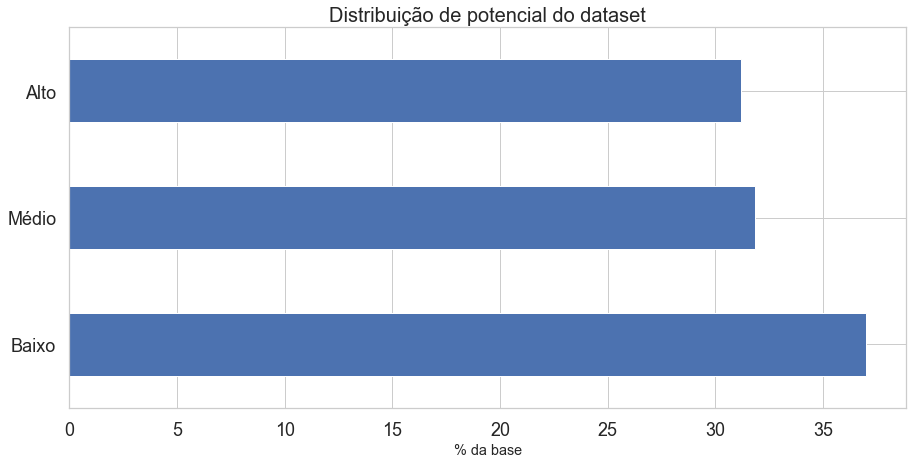

In [195]:
# Vamos usar a função de plot do mult_df, multiplicando por 100 para interpretarmos como percentual
plt.figure(figsize=(15,7))
(mult_df.potencial.value_counts(normalize=True)*100).plot(kind='barh')
plt.title('Distribuição de potencial do dataset',size=20)
plt.xlabel("% da base")
plt.yticks(size=18)
plt.xticks(size=18)
plt.show()

In [196]:
# Separando as features e as variáveis de interesse
X = mult_df.drop(['potencial','cidade','estado','nome','logfaturamento'],axis=1)
y = mult_df.potencial

In [197]:
# Distribuição das classes
mult_df.potencial.value_counts(normalize=True)

Baixo    0.370130
Médio    0.318182
Alto     0.311688
Name: potencial, dtype: float64

In [198]:
# Separação dos dados

X_train, X_test, y_train, y_test = train_test_split(X,y)

In [199]:
y_train.value_counts(normalize=True)

Baixo    0.382609
Médio    0.330435
Alto     0.286957
Name: potencial, dtype: float64

Opções multiclasse na regressão logística
A regressão logística que aprendemos, LogisticRegression() do scikit-learn possui métodos específicos para lidar com problemas multiclasse

In [200]:
# Instanciando uma regressão logística Multiclasse
modelo = LogisticRegression(
    multi_class='ovr' # ovr -> One vs. Rest, específico para multi classes
)

Como vamos usar uma regressão logística, precisamos antes realizar a normalização dos dados! Para isso, vamos usar um StandardScaler:

In [201]:
# Escalando os dados
scaler = StandardScaler()
# Treinando o scaler
scaler.fit(X_train)

# Transformando os dados no treino e no teste -> Só podemos treinar o scaler com os dados de treino!
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

In [202]:
# Treinando o modelo nos dados de treino
modelo.fit(X_train_sc,y_train)

# Prevendo os resultados nos conjuntos de treino e de teste, usando o .predict()
y_pred_train = modelo.predict(X_train_sc)
y_pred_test = modelo.predict(X_test_sc)

# Verificando a base de predição de treino
y_pred_train

array(['Baixo', 'Baixo', 'Baixo', 'Baixo', 'Médio', 'Alto', 'Baixo',
       'Baixo', 'Alto', 'Médio', 'Médio', 'Baixo', 'Baixo', 'Baixo',
       'Baixo', 'Médio', 'Médio', 'Baixo', 'Médio', 'Baixo', 'Alto',
       'Médio', 'Baixo', 'Alto', 'Baixo', 'Alto', 'Alto', 'Médio',
       'Médio', 'Baixo', 'Baixo', 'Médio', 'Alto', 'Alto', 'Médio',
       'Médio', 'Alto', 'Alto', 'Baixo', 'Baixo', 'Baixo', 'Baixo',
       'Baixo', 'Médio', 'Baixo', 'Baixo', 'Baixo', 'Alto', 'Baixo',
       'Baixo', 'Baixo', 'Alto', 'Baixo', 'Médio', 'Médio', 'Alto',
       'Alto', 'Baixo', 'Baixo', 'Baixo', 'Médio', 'Médio', 'Baixo',
       'Baixo', 'Baixo', 'Alto', 'Alto', 'Alto', 'Alto', 'Baixo', 'Alto',
       'Alto', 'Baixo', 'Alto', 'Médio', 'Alto', 'Baixo', 'Alto', 'Baixo',
       'Baixo', 'Baixo', 'Baixo', 'Médio', 'Baixo', 'Alto', 'Alto',
       'Médio', 'Baixo', 'Alto', 'Médio', 'Baixo', 'Alto', 'Baixo',
       'Baixo', 'Baixo', 'Baixo', 'Alto', 'Alto', 'Baixo', 'Baixo',
       'Médio', 'Baixo', 'Baixo

Apenas usando a opção ovr, conseguimos usar a mesma regressão logística (preparada para receber dados binários), mas para problemas multiclasse!

# Avaliando resultados
Vamos agora analisar os resultados do modelo treinado, verificando as métricas que revisamos e também construindo a nossa Matriz de Confusão

In [203]:
# Calculando a matriz de confusão para os dados de treino e teste
matriz_confusao_treino = confusion_matrix(y_train,y_pred_train)
matriz_confusao_teste = confusion_matrix(y_test,y_pred_test)

# Ilustrando o dataset
matriz_confusao_treino

array([[31,  0,  2],
       [ 0, 44,  0],
       [ 2, 15, 21]], dtype=int64)

Como podemos ver, a matriz de confusão é apenas um vetor de vetores, mas podemos melhorar sua visualização se transformarmos esse resultado em um DataFrame

In [204]:
modelo.classes_

array(['Alto', 'Baixo', 'Médio'], dtype=object)

In [205]:
# Transformando a matriz de confusão em um dataframe
df_matriz_confusao_treino = pd.DataFrame(matriz_confusao_treino)
df_matriz_confusao_teste = pd.DataFrame(matriz_confusao_teste)

# Atribuindo as linhas e colunas como sendo o nome das classes
df_matriz_confusao_treino.index = modelo.classes_
df_matriz_confusao_treino.columns = modelo.classes_

df_matriz_confusao_teste.index = modelo.classes_
df_matriz_confusao_teste.columns = modelo.classes_

df_matriz_confusao_treino

,Alto,Baixo,Médio
Alto,31,0,2
Baixo,0,44,0
Médio,2,15,21


Para melhorar ainda mais nossa visualização, vamos fazer um Heatmap do dataframe final:

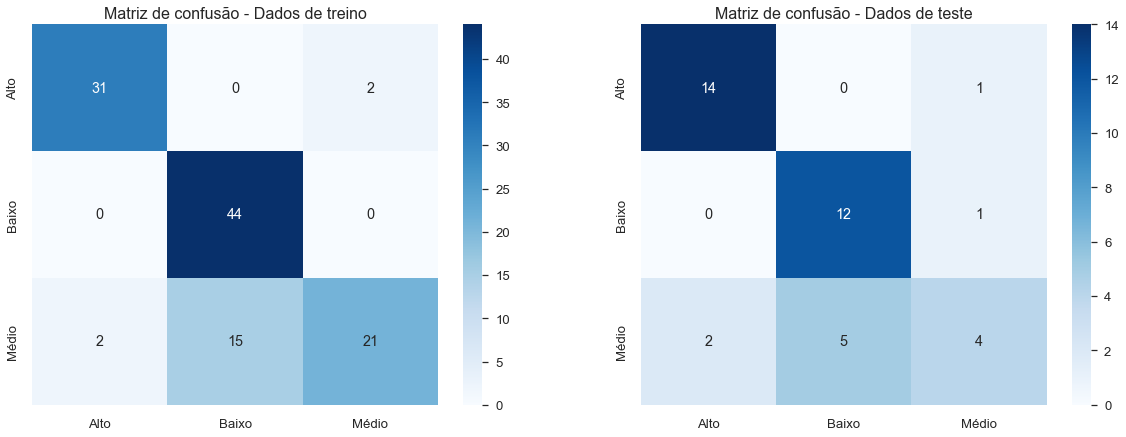

In [206]:
fig, ax = plt.subplots(1,2,figsize=(20,7)) # Grid de gráficos com 1 linha e 2 colunas

# Dados de treino
sns.heatmap(df_matriz_confusao_treino,cmap='Blues',annot=True,fmt='.0f',ax=ax[0])
ax[0].set_title('Matriz de confusão - Dados de treino',size=16)
# Dados de teste
sns.heatmap(df_matriz_confusao_teste,cmap='Blues',annot=True,fmt='.0f',ax=ax[1])
ax[1].set_title('Matriz de confusão - Dados de teste',size=16)
plt.show()

Para podermos ter uma noção melhor, podemos calcular as métricas de precisão e recall. Mas como temos mais do que duas classes, podemos escolher como sumarizar os resultados em micro, macro ou average

In [207]:
# Calculando precisão e recall com diferentes sumarizações

print('Precisão "micro": {:.2f}"'.format(precision_score(y_train,y_pred_train,average='micro')))
print('Precisão "macro": {:.2f}"'.format(precision_score(y_train,y_pred_train,average='macro')))
print('Precisão "weighted": {:.2f}"'.format(precision_score(y_train,y_pred_train,average='weighted')))

Precisão "micro": 0.83"
Precisão "macro": 0.87"
Precisão "weighted": 0.86"


Repetindo o mesmo processo mas agora para sensibilidade/recall:

In [208]:
print('Recall "micro": {:.2f}"'.format(recall_score(y_train,y_pred_train,average='micro')))
print('Recall "macro": {:.2f}"'.format(recall_score(y_train,y_pred_train,average='macro')))
print('Recall "weighted": {:.2f}"'.format(recall_score(y_train,y_pred_train,average='weighted')))

Recall "micro": 0.83"
Recall "macro": 0.83"
Recall "weighted": 0.83"


# Classification report e a métrica local
Um aspecto em problemas multiclasse é o de que cada métrica pode ser calculada para cada uma das classes. E uma forma bastante simples de ver este comportamento é através do classification_report:

In [209]:
# Calculando um classification report dos dados de treino
cl_report_treino = classification_report(y_train,y_pred_train)

# Imprimindo o relatório
print(cl_report_treino)

              precision    recall  f1-score   support

        Alto       0.94      0.94      0.94        33
       Baixo       0.75      1.00      0.85        44
       Médio       0.91      0.55      0.69        38

    accuracy                           0.83       115
   macro avg       0.87      0.83      0.83       115
weighted avg       0.86      0.83      0.82       115



In [210]:
#Vamos representar agora o relatório nos dados de teste:

In [211]:
# Calculando um classification report dos dados de teste
cl_report_teste = classification_report(y_test,y_pred_test)

# Imprimindo o relatório
print(cl_report_teste)

              precision    recall  f1-score   support

        Alto       0.88      0.93      0.90        15
       Baixo       0.71      0.92      0.80        13
       Médio       0.67      0.36      0.47        11

    accuracy                           0.77        39
   macro avg       0.75      0.74      0.72        39
weighted avg       0.76      0.77      0.75        39



# Tentando a abordagem One vs One
Vimos também a possibilidade de usarmos a técnica One versus One, onde treinamos modelos comparando cada classe duas a duas. Para usarmos essa abordagem, podemos usar a função OneVsOneClassifier

In [212]:
# Instanciando o objeto
modelo_onevsone = OneVsOneClassifier(LogisticRegression())

# Treinando o modelo
modelo_onevsone.fit(X_train_sc,y_train)

# Prevendo sobre dados de treino e teste
y_pred_train_ovo = modelo_onevsone.predict(X_train_sc)
y_pred_test_ovo = modelo_onevsone.predict(X_test_sc)

Vamos agora comparar as performances das abordagens One vs All e One vs One

In [213]:
print('Precisão "micro" OvR - Treino: {:.4f}"'.format(precision_score(y_train,y_pred_train,average='micro')))
print('Precisão "micro" OvO - Treino: {:.4f}"'.format(precision_score(y_train,y_pred_train_ovo,average='micro')))
print('---------------------------------------')
print('Precisão "micro" OvR - Teste : {:.4f}"'.format(precision_score(y_test,y_pred_test,average='micro')))
print('Precisão "micro" OvO - Teste : {:.4f}"'.format(precision_score(y_test,y_pred_test_ovo,average='micro')))

Precisão "micro" OvR - Treino: 0.8348"
Precisão "micro" OvO - Treino: 0.8957"
---------------------------------------
Precisão "micro" OvR - Teste : 0.7692"
Precisão "micro" OvO - Teste : 0.8974"


O que precisamos para calcular a curva ROC são as taxas de Falso Positivoe de Verdadeiro Positivo. Porém vimos que podemos calcular estes valores para cada uma das classes! Para nos auxiliar nestes cálculos, podemos usar a função roc_auc da biblioteca Yellowbricks

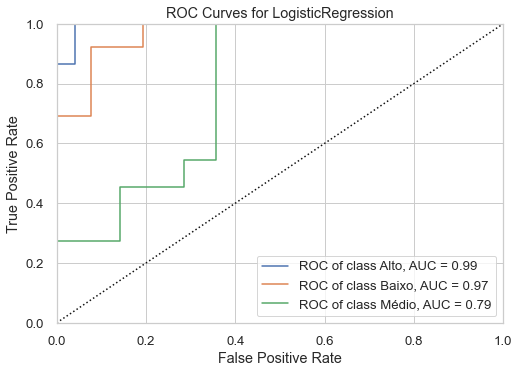

In [214]:

# Curvas ROC - Teste One vs. Rest
roc_auc(estimator=modelo, # Modelo a ser treinado
    X_train=X_train_sc,y_train=y_train,
    X_test=X_test_sc,y_test=y_test,
    micro=False,macro=False, # Indicando que não queremos as curvas de micro e macro
    is_fitted=False # Indicando que o estimador já está treinado
)
plt.show()

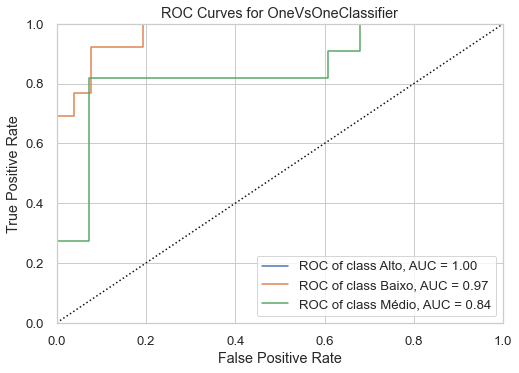

In [215]:
# Curvas ROC - Teste One vs. One
roc_auc(estimator=modelo_onevsone, # Modelo a ser treinado
    X_train=X_train_sc,y_train=y_train,
    X_test=X_test_sc,y_test=y_test,
    micro=False,macro=False, # Indicando que não queremos as curvas de micro e macro
    is_fitted=False # Indicando que o estimador irá ser treinado com os dados
        
)
ax[1].set_title('Curvas ROC - Regressão OvO',size=16)
ax[1].set_xlabel('% falsos positivos',size=14)
ax[1].set_ylabel('% verdadeiros positivos',size=14)
plt.show()

Nosso modelo tomou as decisões diretamente, mas de fato o que ele fez foi escolher com base em cortes de probabilidade. Podemos acessar essas probabilidades com o método .predict_proba() da regressão logística

In [216]:
# Acessando as probabilidades do conjunto de teste, usando o modelo balanceado One vs.rest
y_proba_teste = modelo.predict_proba(X_test_sc)

df_y_proba_teste = pd.DataFrame(y_proba_teste,columns=modelo.classes_) # Colunas serão o nome de cada classe
# Colocando também a decisão final do modelo
df_y_proba_teste['posicao_predita'] = modelo.predict(X_test_sc)
df_y_proba_teste

,Alto,Baixo,Médio,posicao_predita
0,0.103530,6.111728e-01,2.852974e-01,Baixo
1,0.111003,4.605996e-01,4.283975e-01,Baixo
2,0.260872,2.052899e-02,7.185993e-01,Médio
3,0.024773,5.691400e-01,4.060870e-01,Baixo
4,0.220118,4.747322e-01,3.051501e-01,Baixo
5,0.883519,8.302913e-07,1.164807e-01,Alto
6,0.034619,7.070201e-01,2.583605e-01,Baixo
7,0.467938,1.248831e-01,4.071792e-01,Alto
8,0.335211,3.238297e-01,3.409593e-01,Médio
9,0.713981,1.371855e-02,2.723003e-01,Alto


In [217]:
# Marcando a maior probabilidade
df_y_proba_teste['maior_prob'] = df_y_proba_teste[df_y_proba_teste.columns[:-1]].max(axis=1)

# Ordenando do menor para o maior e mostrando os primeiros 10 registros
df_y_proba_teste.sort_values(by='maior_prob').head(10)

,Alto,Baixo,Médio,posicao_predita,maior_prob
8,0.335211,3.238297e-01,0.340959,Médio,0.340959
1,0.111003,4.605996e-01,0.428398,Baixo,0.460600
7,0.467938,1.248831e-01,0.407179,Alto,0.467938
4,0.220118,4.747322e-01,0.305150,Baixo,0.474732
19,0.497735,6.273151e-18,0.502265,Médio,0.502265
21,0.081225,4.134460e-01,0.505329,Médio,0.505329
30,0.544887,7.126951e-03,0.447986,Alto,0.544887
31,0.552112,1.703397e-01,0.277548,Alto,0.552112
20,0.559959,5.460885e-12,0.440041,Alto,0.559959
11,0.139730,5.600576e-01,0.300213,Baixo,0.560058


In [218]:
teste_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 293 entries, 160 to 455
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   nome          293 non-null    object 
 1   cidade        293 non-null    object 
 2   estado        293 non-null    object 
 3   população     293 non-null    int64  
 4   popDe20a24    293 non-null    int64  
 5   popDe25a34    293 non-null    int64  
 6   popDe35a49    293 non-null    int64  
 7   popDe50a59    293 non-null    int64  
 8   popMaisDe60   293 non-null    int64  
 9   domiciliosA1  293 non-null    int64  
 10  domiciliosA2  293 non-null    int64  
 11  domiciliosB1  293 non-null    int64  
 12  domiciliosB2  293 non-null    int64  
 13  domiciliosC1  293 non-null    int64  
 14  domiciliosC2  293 non-null    int64  
 15  domiciliosD   293 non-null    int64  
 16  domiciliosE   293 non-null    int64  
 17  rendaMedia    293 non-null    float64
 18  faturamento   293 non-null  

In [219]:
#agora vamos predizer para o teste final
# Separando as features e as variáveis de interesse
prev_final = teste_final.drop(['cidade','estado','nome'],axis=1)

In [220]:
X_prev_final_sc = scaler.transform(prev_final)

In [221]:
# como o melhor resultado foi do One vs one , vamos aplicar o predict 
y_pred_final_ovo = modelo_onevsone.predict(X_prev_final_sc)

In [222]:
y_pred_final_ovo

array(['Médio', 'Alto', 'Médio', 'Alto', 'Médio', 'Alto', 'Médio', 'Alto',
       'Alto', 'Alto', 'Médio', 'Alto', 'Baixo', 'Alto', 'Baixo', 'Alto',
       'Alto', 'Baixo', 'Alto', 'Alto', 'Médio', 'Alto', 'Alto', 'Baixo',
       'Alto', 'Baixo', 'Alto', 'Baixo', 'Médio', 'Baixo', 'Alto', 'Alto',
       'Alto', 'Médio', 'Médio', 'Alto', 'Médio', 'Alto', 'Baixo',
       'Baixo', 'Alto', 'Baixo', 'Médio', 'Alto', 'Alto', 'Baixo',
       'Baixo', 'Médio', 'Médio', 'Alto', 'Alto', 'Alto', 'Médio', 'Alto',
       'Médio', 'Médio', 'Médio', 'Médio', 'Médio', 'Médio', 'Médio',
       'Alto', 'Alto', 'Médio', 'Baixo', 'Baixo', 'Alto', 'Baixo',
       'Baixo', 'Baixo', 'Médio', 'Baixo', 'Médio', 'Baixo', 'Médio',
       'Médio', 'Médio', 'Alto', 'Baixo', 'Baixo', 'Alto', 'Médio',
       'Alto', 'Médio', 'Médio', 'Médio', 'Alto', 'Baixo', 'Médio',
       'Alto', 'Médio', 'Alto', 'Médio', 'Médio', 'Médio', 'Alto', 'Alto',
       'Baixo', 'Médio', 'Alto', 'Alto', 'Alto', 'Médio', 'Médio', 'Alto',


In [223]:
teste_final['potencial'] = y_pred_final_ovo

In [224]:
teste_final

,nome,cidade,estado,população,popDe20a24,popDe25a34,popDe35a49,popDe50a59,popMaisDe60,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,domiciliosC1,domiciliosC2,domiciliosD,domiciliosE,rendaMedia,faturamento,potencial
160,A. E. Carvalho,São Paulo,SP,94034,7487,14535,21549,10598,10508,0,253,2197,4368,6681,7011,2247,5670,1501.0,2.270064e+05,Médio
161,Aclimação,São Paulo,SP,32791,2197,5341,7281,4917,7645,1413,1734,3704,2351,1946,827,291,1617,5920.0,1.536334e+06,Alto
162,Adventista,São Paulo,SP,104193,8657,17749,23364,11567,9812,0,0,1423,4875,8595,10082,3111,5776,1284.0,3.028518e+05,Médio
163,Água Branca,São Paulo,SP,12721,819,2142,2833,1790,3214,624,667,1558,1032,915,361,84,404,6278.0,1.148847e+06,Alto
164,Água Funda,São Paulo,SP,48417,3571,7388,10751,6648,8567,0,303,1794,2986,4489,2836,1104,2553,1905.0,7.309646e+05,Médio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,Vila Sônia,São Paulo,SP,34061,2076,4579,7557,5227,7999,942,1089,2866,2219,2216,1227,306,1098,5285.0,1.288329e+06,Alto
452,Vila Suzana,São Paulo,SP,35403,2433,5855,9107,4608,4705,1726,1522,2458,1186,1166,918,209,3840,7418.0,1.444415e+06,Alto
453,Vila Terezinha,São Paulo,SP,122359,9965,19248,26592,12579,13109,0,0,1758,4517,9450,11473,3218,7540,1252.0,2.725857e+05,Médio
454,Vila Zatt,São Paulo,SP,125864,9338,18841,28500,16700,19285,8,872,5093,8063,10012,8082,2856,6853,1936.0,2.725857e+05,Alto


Agora vamos olhar para o potencial do público adultos e das
classes(rendas)

In [324]:
#Mudando o nome da coluna 'nome' para 'bairro'

In [325]:
teste_final.rename(columns={'nome': 'bairro'}, inplace = True)
teste_final

,bairro,cidade,estado,população,popDe20a24,popDe25a34,popDe35a49,popDe50a59,popMaisDe60,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,domiciliosC1,domiciliosC2,domiciliosD,domiciliosE,rendaMedia,faturamento,potencial
160,A. E. Carvalho,São Paulo,SP,94034,7487,14535,21549,10598,10508,0,253,2197,4368,6681,7011,2247,5670,1501.0,2.270064e+05,Médio
161,Aclimação,São Paulo,SP,32791,2197,5341,7281,4917,7645,1413,1734,3704,2351,1946,827,291,1617,5920.0,1.536334e+06,Alto
162,Adventista,São Paulo,SP,104193,8657,17749,23364,11567,9812,0,0,1423,4875,8595,10082,3111,5776,1284.0,3.028518e+05,Médio
163,Água Branca,São Paulo,SP,12721,819,2142,2833,1790,3214,624,667,1558,1032,915,361,84,404,6278.0,1.148847e+06,Alto
164,Água Funda,São Paulo,SP,48417,3571,7388,10751,6648,8567,0,303,1794,2986,4489,2836,1104,2553,1905.0,7.309646e+05,Médio
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,Vila Sônia,São Paulo,SP,34061,2076,4579,7557,5227,7999,942,1089,2866,2219,2216,1227,306,1098,5285.0,1.288329e+06,Alto
452,Vila Suzana,São Paulo,SP,35403,2433,5855,9107,4608,4705,1726,1522,2458,1186,1166,918,209,3840,7418.0,1.444415e+06,Alto
453,Vila Terezinha,São Paulo,SP,122359,9965,19248,26592,12579,13109,0,0,1758,4517,9450,11473,3218,7540,1252.0,2.725857e+05,Médio
454,Vila Zatt,São Paulo,SP,125864,9338,18841,28500,16700,19285,8,872,5093,8063,10012,8082,2856,6853,1936.0,2.725857e+05,Alto


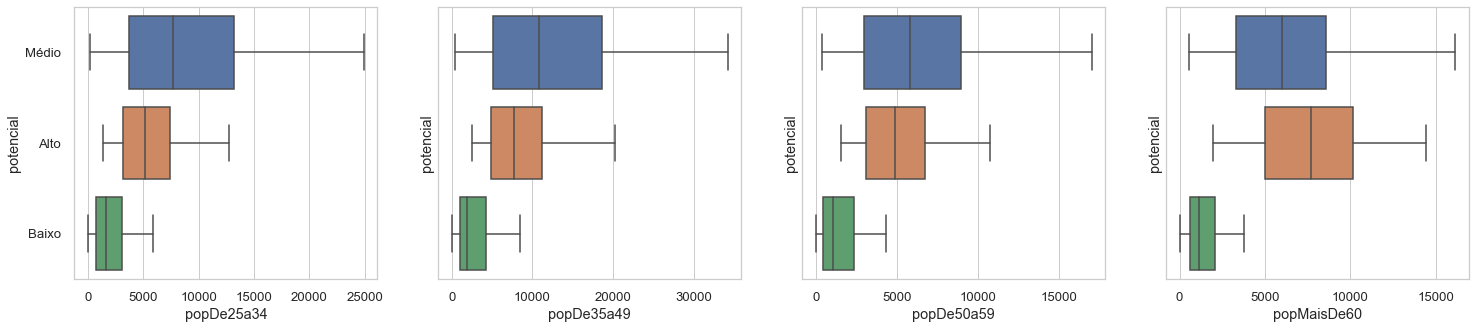

In [326]:
# Vamos fazer isso usando o comando 'for' pois o código fica mais enxuto
plt.rcParams['font.size'] = '14' # Para ajustar o tamanho de todas as fontes do matplotlib ao mesmo tempo
features_boxplot = ['popDe25a34','popDe35a49','popDe50a59','popMaisDe60']

fig, ax = plt.subplots(1,4,figsize=(25,5),sharey=True) # Construindo um 'grid' de gráficos de 1 linha e 4 colunas
for i in range(4):
    sns.boxplot(teste_final[features_boxplot[i]],teste_final.potencial,ax=ax[i],showfliers=False) #fliers são os outliers, não estamos mostrando

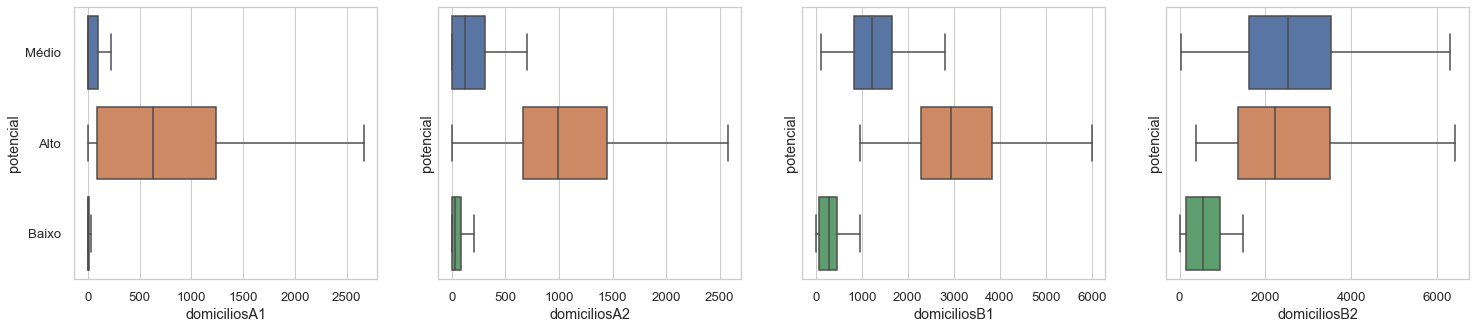

In [327]:
# Vamos fazer isso usando o comando 'for' pois o código fica mais enxuto
plt.rcParams['font.size'] = '14' # Para ajustar o tamanho de todas as fontes do matplotlib ao mesmo tempo
features_boxplot = ['domiciliosA1','domiciliosA2','domiciliosB1','domiciliosB2']

fig, ax = plt.subplots(1,4,figsize=(25,5),sharey=True) # Construindo um 'grid' de gráficos de 1 linha e 4 colunas
for i in range(4):
    sns.boxplot(teste_final[features_boxplot[i]],teste_final.potencial,ax=ax[i],showfliers=False) #fliers são os outliers, não estamos mostrando

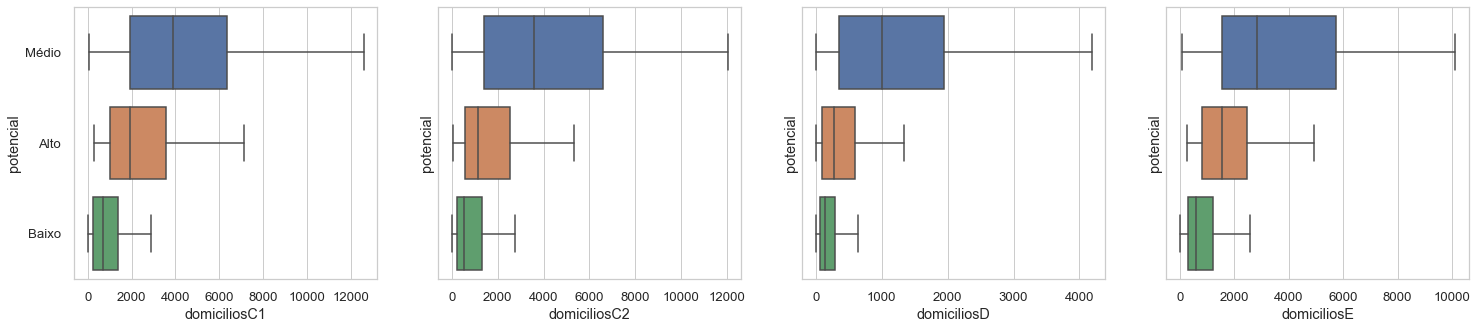

In [328]:
# Vamos fazer isso usando o comando 'for' pois o código fica mais enxuto
plt.rcParams['font.size'] = '14' # Para ajustar o tamanho de todas as fontes do matplotlib ao mesmo tempo
features_boxplot = ['domiciliosC1','domiciliosC2','domiciliosD','domiciliosE']

fig, ax = plt.subplots(1,4,figsize=(25,5),sharey=True) # Construindo um 'grid' de gráficos de 1 linha e 4 colunas
for i in range(4):
    sns.boxplot(teste_final[features_boxplot[i]],teste_final.potencial,ax=ax[i],showfliers=False) #fliers são os outliers, não estamos mos

In [230]:
# agora vamos segmentar por bairro

In [329]:
bairro = teste_final.bairro.value_counts(3).nlargest(10).index
bairro

Index(['A. E. Carvalho', 'Parque Ecológico Tietê', 'Pinheiros', 'Perus',
       'Perdizes', 'Penha', 'Pedreira', 'Parque Savoy', 'Parque São Rafael',
       'Parque São Lucas'],
      dtype='object')

In [330]:
# dez maiores faturamentos por bairros

keys = []
values = []
faturamento_list = []

for bar in bairro:
    keys.append(bar)
    values.append(round((teste_final[teste_final['bairro'] == bar]['faturamento']).sum(),2))
    
faturamento_list = list(zip(keys, values))
faturamento_list

[('A. E. Carvalho', 227006.42),
 ('Parque Ecológico Tietê', 769808.85),
 ('Pinheiros', 1180726.95),
 ('Perus', 267327.89),
 ('Perdizes', 1928248.52),
 ('Penha', 871583.6),
 ('Pedreira', 309503.46),
 ('Parque Savoy', 625344.65),
 ('Parque São Rafael', 390268.19),
 ('Parque São Lucas', 679814.96)]

In [331]:
# armanzenando os maiores faturamentos por bairro em um DataFrame
df_faturamento = pd.DataFrame(faturamento_list,columns=['bairro','faturamento'])
df_faturamento.sort_values(by=['faturamento'],ascending=False)


,bairro,faturamento
4,Perdizes,1928248.52
2,Pinheiros,1180726.95
5,Penha,871583.60
1,Parque Ecológico Tietê,769808.85
9,Parque São Lucas,679814.96
7,Parque Savoy,625344.65
8,Parque São Rafael,390268.19
6,Pedreira,309503.46
3,Perus,267327.89
0,A. E. Carvalho,227006.42


In [355]:
# plotando os 20 maiores faturamentos dos bairros com potencial alto visando público alvo
import plotly.express as px
fig = px.bar(df_faturamento.sort_values(by=['faturamento'],ascending=False), x='bairro', y='faturamento',color='bairro',height=400)
fig.show()

In [333]:
teste_final.info()
#df_segmentado = teste_final['popDe25a34','popDe35a49','domiciliosA1','domiciliosA2','domiciliosB1','domiciliosB2','faturamento','potencial']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 293 entries, 160 to 455
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   bairro        293 non-null    object 
 1   cidade        293 non-null    object 
 2   estado        293 non-null    object 
 3   população     293 non-null    int64  
 4   popDe20a24    293 non-null    int64  
 5   popDe25a34    293 non-null    int64  
 6   popDe35a49    293 non-null    int64  
 7   popDe50a59    293 non-null    int64  
 8   popMaisDe60   293 non-null    int64  
 9   domiciliosA1  293 non-null    int64  
 10  domiciliosA2  293 non-null    int64  
 11  domiciliosB1  293 non-null    int64  
 12  domiciliosB2  293 non-null    int64  
 13  domiciliosC1  293 non-null    int64  
 14  domiciliosC2  293 non-null    int64  
 15  domiciliosD   293 non-null    int64  
 16  domiciliosE   293 non-null    int64  
 17  rendaMedia    293 non-null    float64
 18  faturamento   293 non-null  

In [334]:
df_segmentado = teste_final.drop(['popDe20a24','popDe50a59','popMaisDe60','domiciliosC1','domiciliosC2','domiciliosD','domiciliosE'],axis=1)

In [335]:
df_segmentado

,bairro,cidade,estado,população,popDe25a34,popDe35a49,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,rendaMedia,faturamento,potencial
160,A. E. Carvalho,São Paulo,SP,94034,14535,21549,0,253,2197,4368,1501.0,2.270064e+05,Médio
161,Aclimação,São Paulo,SP,32791,5341,7281,1413,1734,3704,2351,5920.0,1.536334e+06,Alto
162,Adventista,São Paulo,SP,104193,17749,23364,0,0,1423,4875,1284.0,3.028518e+05,Médio
163,Água Branca,São Paulo,SP,12721,2142,2833,624,667,1558,1032,6278.0,1.148847e+06,Alto
164,Água Funda,São Paulo,SP,48417,7388,10751,0,303,1794,2986,1905.0,7.309646e+05,Médio
...,...,...,...,...,...,...,...,...,...,...,...,...,...
451,Vila Sônia,São Paulo,SP,34061,4579,7557,942,1089,2866,2219,5285.0,1.288329e+06,Alto
452,Vila Suzana,São Paulo,SP,35403,5855,9107,1726,1522,2458,1186,7418.0,1.444415e+06,Alto
453,Vila Terezinha,São Paulo,SP,122359,19248,26592,0,0,1758,4517,1252.0,2.725857e+05,Médio
454,Vila Zatt,São Paulo,SP,125864,18841,28500,8,872,5093,8063,1936.0,2.725857e+05,Alto


In [336]:
# separando o dataframe por potencial alto
df_segmentado_alto = df_segmentado[df_segmentado['potencial']== 'Alto']

In [337]:
df_segmentado_alto

,bairro,cidade,estado,população,popDe25a34,popDe35a49,domiciliosA1,domiciliosA2,domiciliosB1,domiciliosB2,rendaMedia,faturamento,potencial
161,Aclimação,São Paulo,SP,32791,5341,7281,1413,1734,3704,2351,5920.0,1.536334e+06,Alto
163,Água Branca,São Paulo,SP,12721,2142,2833,624,667,1558,1032,6278.0,1.148847e+06,Alto
165,Água Rasa,São Paulo,SP,26134,3625,5837,559,866,2367,1906,5907.0,1.155300e+06,Alto
167,Alfredo Pujol,São Paulo,SP,39310,5431,8457,1556,1995,4558,2845,6586.0,1.596560e+06,Alto
168,Alto Da Lapa,São Paulo,SP,15551,1967,3557,839,825,1485,934,8303.0,1.176556e+06,Alto
...,...,...,...,...,...,...,...,...,...,...,...,...,...
445,Vila Prudente,São Paulo,SP,37320,5162,8384,519,1249,3099,2715,4497.0,1.272333e+06,Alto
448,Vila Santa Catarina,São Paulo,SP,64419,10517,15425,1067,1855,4814,3376,4148.0,1.480173e+06,Alto
451,Vila Sônia,São Paulo,SP,34061,4579,7557,942,1089,2866,2219,5285.0,1.288329e+06,Alto
452,Vila Suzana,São Paulo,SP,35403,5855,9107,1726,1522,2458,1186,7418.0,1.444415e+06,Alto


In [338]:
p_alto = df_segmentado_alto.bairro.value_counts(3).nlargest(20).index
p_alto

Index(['Aclimação', 'Ponte Rasa', 'Tietê', 'Tatuapé', 'Sumaré', 'Saúde',
       'São João Climaco', 'Santo Amaro', 'Santa Cruz', 'Santa Clara',
       'Santa Cecília/Campos Elísios', 'Sacomã', 'Rio Pequeno', 'Real Parque',
       'Puc', 'Pompéia', 'Tremembé', 'Planalto Paulista', 'Pirituba',
       'Piqueri/Parque São Jorge'],
      dtype='object')

In [339]:
#20 maiores faturamentos por bairros com potencial Alto

keys = []
values = []
faturamento_list20 = []

for alto in p_alto:
    keys.append(alto)
    values.append(round((df_segmentado_alto[df_segmentado_alto['bairro'] == alto]['faturamento']).sum(),2))
    
faturamento_list20 = list(zip(keys, values))
faturamento_list20

[('Aclimação', 1536334.01),
 ('Ponte Rasa', 810691.03),
 ('Tietê', 1294616.2),
 ('Tatuapé', 1633697.38),
 ('Sumaré', 1330201.72),
 ('Saúde', 1711706.2),
 ('São João Climaco', 899954.83),
 ('Santo Amaro', 1371920.96),
 ('Santa Cruz', 1180726.95),
 ('Santa Clara', 850674.31),
 ('Santa Cecília/Campos Elísios', 1210249.55),
 ('Sacomã', 676964.51),
 ('Rio Pequeno', 1026932.72),
 ('Real Parque', 1232780.04),
 ('Puc', 1389467.89),
 ('Pompéia', 1330201.72),
 ('Tremembé', 1020363.93),
 ('Planalto Paulista', 1294440.53),
 ('Pirituba', 943650.33),
 ('Piqueri/Parque São Jorge', 1482967.9)]

In [340]:
# armanzenando os 20 maiores faturamentos por bairro com potencial alto e idade entre 20 e 50
df_faturamento_alto = pd.DataFrame(faturamento_list20,columns=['bairro','faturamento'])
df_faturamento_alto.sort_values(by=['faturamento'],ascending=False)

,bairro,faturamento
5,Saúde,1711706.20
3,Tatuapé,1633697.38
0,Aclimação,1536334.01
19,Piqueri/Parque São Jorge,1482967.90
14,Puc,1389467.89
7,Santo Amaro,1371920.96
4,Sumaré,1330201.72
15,Pompéia,1330201.72
2,Tietê,1294616.20
17,Planalto Paulista,1294440.53


In [354]:
# plotando os 20 maiores faturamentos dos bairros com potencial alto visando público alvo
import plotly.express as px
fig = px.bar(df_faturamento_alto.sort_values(by=['faturamento'],ascending=False), x='bairro', y='faturamento',color='bairro',height=400)
fig.show()

In [342]:
# separando o dataframe por potencial medio
df_segmentado_medio = df_segmentado[df_segmentado['potencial']== 'Médio']

In [343]:
p_medio = df_segmentado_medio.bairro.value_counts(3).nlargest(20).index
p_medio

Index(['A. E. Carvalho', 'Parque Savoy', 'Parque Santa Madalena',
       'Parque Novo Mundo', 'Parque Morro Doce', 'Parque Ibirapuera',
       'Parque Fernanda', 'Parque Buturussu', 'Parque Arariba', 'Parelheiros',
       'Parada Quinze', 'Parada De Taipas', 'Palmas Do Tremembé', 'Pacaembu',
       'Nova Jaraguá', 'M'Boi Mirim', 'Mar Paulista', 'Luz', 'Limoeiro',
       'Liberdade/São Joaquim'],
      dtype='object')

In [344]:
#20 maiores faturamentos por bairros com potencial Alto

keys = []
values = []
faturamento_medio20 = []

for medio in p_medio:
    keys.append(medio)
    values.append(round((df_segmentado_medio[df_segmentado_medio['bairro'] == medio]['faturamento']).sum(),2))
    
faturamento_medio20 = list(zip(keys, values))
faturamento_medio20

[('A. E. Carvalho', 227006.42),
 ('Parque Savoy', 625344.65),
 ('Parque Santa Madalena', 227006.42),
 ('Parque Novo Mundo', 565209.59),
 ('Parque Morro Doce', 544510.37),
 ('Parque Ibirapuera', 1123149.54),
 ('Parque Fernanda', 272585.71),
 ('Parque Buturussu', 757584.09),
 ('Parque Arariba', 599700.03),
 ('Parelheiros', 247975.03),
 ('Parada Quinze', 748472.88),
 ('Parada De Taipas', 272585.71),
 ('Palmas Do Tremembé', 824000.66),
 ('Pacaembu', 1146557.66),
 ('Nova Jaraguá', 720656.96),
 ("M'Boi Mirim", 163563.91),
 ('Mar Paulista', 694471.63),
 ('Luz', 873543.93),
 ('Limoeiro', 272585.71),
 ('Liberdade/São Joaquim', 967016.78)]

In [345]:
# armanzenando os 20 maiores faturamentos por bairro com potencial medio e idade entre 20 e 50
df_faturamento_medio = pd.DataFrame(faturamento_medio20,columns=['bairro','faturamento'])
df_faturamento_medio.sort_values(by=['faturamento'],ascending=False)

,bairro,faturamento
13,Pacaembu,1146557.66
5,Parque Ibirapuera,1123149.54
19,Liberdade/São Joaquim,967016.78
17,Luz,873543.93
12,Palmas Do Tremembé,824000.66
7,Parque Buturussu,757584.09
10,Parada Quinze,748472.88
14,Nova Jaraguá,720656.96
16,Mar Paulista,694471.63
1,Parque Savoy,625344.65


In [353]:
# plotando os 20 maiores faturamentos dos bairros com potencial medio visando público alvo
import plotly.express as px
fig = px.bar(df_faturamento_medio.sort_values(by=['faturamento'],ascending=False), x='bairro', y='faturamento',color='bairro',height=400)
fig.show()